In [1]:
import numpy as np
import matplotlib.pyplot as plt
import LISA_utils  # This is a python script full of nice tasty functions we can use for LISA (or LIGO) DA
import scipy
import scipy.signal
import scipy.constants
import os
from scipy import integrate
plt.rcParams['agg.path.chunksize'] = 10000

In [2]:
# Bunch of units

GM_sun = 1.3271244*1e20
c =2.9979246*1e8
M_sun =1.9884099*1e30
G = 6.6743*1e-11
pc= 3.0856776*1e16
pi = np.pi
Mpc = (10**6) * pc

In [3]:
def htilde(f,eps,params):
    
    """
    Here we calculate a TaylorF2 model up to 2PN which takes as input the following
    set of parameters: (log of chirp mass, symmetric mass ratio, beta).
    This can easily be changed in the first few lines where the parameters are loaded.
    The main reference is https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)].
    
    Note on distance: 
    
    Notice that the effective distance contains information about the angular dependence
    of the binary. The model can thus be used for all detectors, as long as this distance
    parameter is chosen consistently. 
    
    Note on spin: 
    
    The spin parameter beta is defined in Eq.(2.3a) in [arxiv:0411129].
    Notice that this quantity is constructed in such a way to be smaller or equal
    than 9.4, and of course it ranges from 0 (no spins) to this upper value. 
    The coefficient enters the phase as in Eq.(2.2) in the same paper.
    """
    # Units
    
#     GM_sun = 1.3271244*1e20
#     c =2.9979246*1e8
#     M_sun =1.9884099*1e30
#     G = 6.6743*1e-11
#     pc= 3.0856776*1e16
#     pi = np.pi
#     Mpc = 10**6 * pc
    
    # Load the parameters
    Mchirp_true = M_sun * np.exp(params[0])
    eta_true = params[1]
    beta_true = params[2]
    Deff = params[3]
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    # PN expansion parameter (velocity).
    
    v = (pi*G*Mchirp_true*eta_true**(-3/5)/(c**3) * f)**(1/3)
    # Amplitude explicitly given in terms of units and frequency.
    # Notice that lowest PN order here is fine. Biggest contributions from phase.
    
    amplitude_1 = - (Mpc/Deff)*np.sqrt((5/(24*pi)))*(GM_sun/(c**2 *Mpc))
    amplitude_2 = (pi*GM_sun/(c**3))**(-1/6) * (Mchirp_true/M_sun)**(5/6)
    amplitude = amplitude_1*amplitude_2 * f**(-7/6)
    # Phase: add or remove PN orders here as you see fit.
    
    psi_const = 2*pi*f*t0 - 2*phi0 - pi/4
    psi1PN = (3715/756 + (55/9)*eta_true)*v**(-3)
    psi1_5PN_tails = -16*pi*v**(-2)
    psi1_5PN_spin = 4*beta_true*v**(-2)
    
    psi2PN = (15293365/508032+(27145/504)*eta_true+(3085/72)*eta_true**2)*v**(-1)
    psi25PNlog = pi*(38645/252- (65/3) *eta_true)* np.log(v)
    psi3PN = v*(11583231236531/4694215680 - (640/3) * (pi**2) -6848/21 *np.euler_gamma
              + eta_true*(-15335597827/3048192 + (2255/12) * (pi**2) - 1760/3 * theta - 12320/9 * delta)
              + (eta_true**2) *76055/1728 - (eta_true**3) * 127825/1296 - 6848/21 * np.log(4))
    psi3PNlog = - 6848/21 *v * np.log(v)
    psi35PN = pi * v**2 * (77096675./254016 + (378515./1512) *eta_true - 74045./756 * (eta_true**2)* (1-eps))
    psi_fullPN = (3/(128*eta_true))*(v**(-5)+psi1PN+psi1_5PN_tails+psi1_5PN_spin+psi2PN
                                  + psi25PNlog + psi3PN + psi3PNlog + psi35PN)
    psi = psi_const + psi_fullPN 
    return amplitude* np.exp(-1j*psi)

def htilde_GB(f,params):
    
    """
    Here we calculate a TaylorF2 model up to 2PN which takes as input the following
    set of parameters: (log of chirp mass, symmetric mass ratio, beta).
    This can easily be changed in the first few lines where the parameters are loaded.
    The main reference is https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)].
    
    Note on distance: 
    
    Notice that the effective distance contains information about the angular dependence
    of the binary. The model can thus be used for all detectors, as long as this distance
    parameter is chosen consistently. 
    
    Note on spin: 
    
    The spin parameter beta is defined in Eq.(2.3a) in [arxiv:0411129].
    Notice that this quantity is constructed in such a way to be smaller or equal
    than 9.4, and of course it ranges from 0 (no spins) to this upper value. 
    The coefficient enters the phase as in Eq.(2.2) in the same paper.
    """
    # Units
    
#     GM_sun = 1.3271244*1e20
#     c =2.9979246*1e8
#     M_sun =1.9884099*1e30
#     G = 6.6743*1e-11
#     pc= 3.0856776*1e16
#     pi = np.pi
#     Mpc = 10**6 * pc
    
    # Load the parameters
    Mchirp_true = M_sun * np.exp(params[0])
    eta_true = params[1]
    Deff = params[2]
    

    # PN expansion parameter (velocity).
    
    v = (pi*G*Mchirp_true*eta_true**(-3/5)/(c**3) * f)**(1/3)
    # Amplitude explicitly given in terms of units and frequency.
    # Notice that lowest PN order here is fine. Biggest contributions from phase.
    
    amplitude_1 = - (1/Deff)*np.sqrt((5/(24*pi)))*(GM_sun/(c**2 ))
    amplitude_2 = (pi*GM_sun/(c**3))**(-1/6) * (Mchirp_true/M_sun)**(5/6)
    amplitude = amplitude_1*amplitude_2 * f**(-7/6)
    
    new_amplitude = -np.sqrt(5*np.pi/24)*(G*Mchirp_true/(c**3))*(G*Mchirp_true/(Deff*c**2))*(f*np.pi*G*Mchirp_true/(c**3))**(-7/6)
    
    # Phase: add or remove PN orders here as you see fit.
    
    psi_const = 2*pi*f*t0 - 2*phi0 - pi/4
#     psi1PN = (3715/756 + (55/9)*eta_true)*v**(-3)
#     psi1_5PN_tails = -16*pi*v**(-2)
#     psi1_5PN_spin = 4*beta_true*v**(-2)
    
#     psi2PN = (15293365/508032+(27145/504)*eta_true+(3085/72)*eta_true**2)*v**(-1)
#     psi25PNlog = pi*(38645/252- (65/3) *eta_true)* np.log(v)
#     psi3PN = v*(11583231236531/4694215680 - (640/3) * (pi**2) -6848/21 *np.euler_gamma
#               + eta_true*(-15335597827/3048192 + (2255/12) * (pi**2) - 1760/3 * theta - 12320/9 * delta)
#               + (eta_true**2) *76055/1728 - (eta_true**3) * 127825/1296 - 6848/21 * np.log(4))
#     psi3PNlog = - 6848/21 *v * np.log(v)
#     psi35PN = pi * v**2 * (77096675./254016 + (378515./1512) *eta_true - 74045./756 * (eta_true**2)* (1-eps))
    psi_fullPN = (3/(128*eta_true))*(v**(-5) )
                                    #+psi1PN+psi1_5PN_tails+psi1_5PN_spin+psi2PN
                                  #+ psi25PNlog + psi3PN + psi3PNlog + psi35PN)
    psi = psi_const + psi_fullPN 
    return amplitude_1,amplitude_2,np.exp(-1j*psi),new_amplitude* np.exp(-1j*psi)



# def htilde_AP(f,params):
    
#     """
#     Here we calculate a TaylorF2 model up to 2PN which takes as input the following
#     set of parameters: (log of chirp mass, symmetric mass ratio, beta).
#     This can easily be changed in the first few lines where the parameters are loaded.
#     The main reference is https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)].
    
#     Note on distance: 
    
#     Notice that the effective distance contains information about the angular dependence
#     of the binary. The model can thus be used for all detectors, as long as this distance
#     parameter is chosen consistently. 
    
#     Note on spin: 
    
#     The spin parameter beta is defined in Eq.(2.3a) in [arxiv:0411129].
#     Notice that this quantity is constructed in such a way to be smaller or equal
#     than 9.4, and of course it ranges from 0 (no spins) to this upper value. 
#     The coefficient enters the phase as in Eq.(2.2) in the same paper.
#     """
#     # Units
    
# #     GM_sun = 1.3271244*1e20
# #     c =2.9979246*1e8
# #     M_sun =1.9884099*1e30
# #     G = 6.6743*1e-11
# #     pc= 3.0856776*1e16
# #     pi = np.pi
# #     Mpc = 10**6 * pc
    
#     # Load the parameters
    
#     Mchirp_true = M_sun * np.exp(params[0])
#     eta_true = params[1]
#     beta_true = params[2]
#     Deff = params[3]
#     theta = -11831/9240 #in PN coefficients!
#     delta = -1987/3080  #in PN coefficients!
#     # PN expansion parameter (velocity).
    
#     v = (pi*G*Mchirp_true*eta_true**(-3/5)/(c**3) * f)**(1/3)
#     # Amplitude explicitly given in terms of units and frequency.
#     # Notice that lowest PN order here is fine. Biggest contributions from phase.
    
#     amplitude_1 = - (Mpc/Deff)*np.sqrt((5/(24*pi)))*(GM_sun/(c**2 *Mpc))
#     amplitude_2 = (pi*GM_sun/(c**3))**(-1/6) * (Mchirp_true/M_sun)**(5/6)
#     amplitude = amplitude_1*amplitude_2 * f**(-7/6)
#     # Phase: add or remove PN orders here as you see fit.
    
#     psi_const = 2*pi*f*t0 - 2*phi0 - pi/4
#     psi1PN = (3715/756+55/9*eta_true)*v**(-3)
#     psi1_5PN_tails = -16*pi*v**(-2)
#     psi1_5PN_spin = 4*beta_true*v**(-2)
#     psi2PN = (15293365/508032+27145/504*eta_true+3085/72*eta_true**2)*v**(-1)
#     psi25PNlog = pi*(38645/252- 65/3 *eta_true)* np.log(v)
#     psi3PN = v*(11583231236531/4694215680 -640/3 * pi**2 -6848/21 *np.euler_gamma
#               + eta_true*(-15335597827/3048192+2255/12 * pi**2-1760/3 * theta - 12320/9 * delta)
#               + eta_true**2 *76055/1728 - eta_true**3 * 127825/1296 - 6848/21 * np.log(4))
#     psi3PNlog = - 6848/21 *v * np.log(v)
#     psi35PN = pi * v**2 * (77096675./254016 + 378515./1512 *eta_true - 74045./756 * eta_true**2)
#     psi_fullPN = 3/(128*eta_true)*(v**(-5)+psi1PN+psi1_5PN_tails+psi1_5PN_spin+psi2PN
#                                   + psi25PNlog + psi3PN + psi3PNlog + psi35PN)
#     psi = psi_const + psi_fullPN 
#     return amplitude* np.exp(-1j*psi)

def T_chirp(fmin,M_chirp,eta):

    M = (m1 + m2)*M_sun
    M_chirp *= M_sun
    
    M = M_chirp*eta**(-3/5)
    v_low = (pi*G*M_chirp*eta**(-3/5)/(c**3) * fmin)**(1/3)
    
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    gamma = np.euler_gamma
    
    pre_fact = ((5/(256*eta)) * G*M/(c**3))
    first_term = (v_low**(-8) + (743/252 + (11/3) * eta ) * (v_low **(-6)) - (32*np.pi/5)*v_low**(-5)
                +(3058673/508032 + (5429/504)*eta + (617/72)*eta**2)*v_low**(-4)
                 +(13*eta/3 - 7729/252)*np.pi*v_low**-3)
    
    second_term = (6848*gamma/105 - 10052469856691/23471078400 + 128*pi**2/3 + (
    3147553127/3048192 - 451*(pi**2)/12)*eta - (15211*eta**2)/1728 + (2555*eta**3 / 1296) +
                   (6848/105)*np.log(4*v_low))*v_low**-2
    
    third_term = ((14809/378)*eta**2 - (75703/756) * eta - 15419335/127008)*pi*v_low**-1
    return pre_fact * (first_term + second_term + third_term)

def final_frequency(M_chirp,eta):
    M_tot = M_chirp*eta**(-3/5) * M_sun
    
    return (c**3)/(6*np.sqrt(6)*np.pi*G*M_tot)
    


In [4]:

def inner_prod(sig1_f,sig2_f,PSD,delta_f):
    """
    Wiener Product with constant PSD. Here we use Parseval's theorem. Note the definition of the SNR.
    """
    return (4*delta_f)  * np.real(sum(sig1_f*np.conjugate(sig2_f)/PSD))

def FFT(sig_t,window):
    sig_t_w_pad = LISA_utils.zero_pad(window * sig_t)
    
    return np.fft.rfft(sig_t_w_pad)[1:]

def inner_prod_TD(sig1_f,sig2_f,PSD,n_t,delta_t):
    """
    Wiener Product with constant PSD. Here we use Parseval's theorem. Note the definition of the SNR.
    """
    return (4*delta_t/n_t)  * np.real(sum(sig1_f*np.conjugate(sig2_f)/PSD))

def FFT(sig_t,window):
    sig_t_w_pad = LISA_utils.zero_pad(window * sig_t)
    
    return np.fft.rfft(sig_t_w_pad)[1:]

def window_zero_pad(waveform,N_t):
    """
    There is a bias when alpha \neq 0. Need to fix this. 
    """
    taper = scipy.signal.tukey(len(waveform),0)
    waveform *= taper
    waveform_w_pad = np.pad(waveform, (0, N_t - len(waveform)), 'constant', constant_values=(0))
    
    return waveform_w_pad
    
    



In [5]:
"""
Signal parameters
"""

# Fix these two impostors, assume they are known perfectly.
t0 =1.
phi0 =0.
fmin = 1e-4

# variables to sample through

#logDeff_true = np.log(10**2 *Mpc)

Deff_1 = 2 * 1e3 * Mpc
beta_1 = 6
m1 = 1e6  
m2 = 2*1e6
M_tot_1 = (m1 + m2)  # M_tot in kilograms
eta_1 = (m1*m2)/(M_tot_1**2)  # Symmetric mass ratio [dimensionless]=
M_chirp_1 = M_tot_1*eta_1**(3/5)  # Chirp mass in units of kilograms 


f_max_1 = final_frequency(M_chirp_1,eta_1)  # Calculate maximum frequency (Schwarzschild ISCO frequency)
t_max_1 = T_chirp(fmin,M_chirp_1,eta_1)     # Calculate maximum chirping time that binary radiates stuff

Deff_2 = 3*1e3 * Mpc
beta_2 = 7
m1 = 5*1e6  
m2 = 1*1e6
M_tot_2 = (m1 + m2)  # M_tot in kilograms
eta_2 = (m1*m2)/(M_tot_2**2)  # Symmetric mass ratio [dimensionless]=
M_chirp_2 = M_tot_2*eta_2**(3/5)  # Chirp mass in units of kilograms 

f_max_2 = final_frequency(M_chirp_2,eta_2)  # Calculate maximum frequency (Schwarzschild ISCO frequency)
t_max_2 = T_chirp(fmin,M_chirp_2,eta_2)     # Calculate maximum chirping time that binary radiates stuff

Deff_3 = 1*1e3 * Mpc
beta_3 = 8
m1 = 2*1e6  
m2 = 5*1e6
M_tot_3 = (m1 + m2)  # M_tot in kilograms
eta_3 = (m1*m2)/(M_tot_3**2)  # Symmetric mass ratio [dimensionless]=
M_chirp_3 = M_tot_3*eta_3**(3/5)  # Chirp mass in units of kilograms 

f_max_3 = final_frequency(M_chirp_3,eta_3)  # Calculate maximum frequency (Schwarzschild ISCO frequency)
t_max_3 = T_chirp(fmin,M_chirp_3,eta_3)     # Calculate maximum chirping time that binary radiates stuff

Deff_4 = 1*1e3 * Mpc
beta_4 = 9
m1 = 3*1e6  
m2 = 2*1e6
M_tot_4 = (m1 + m2)  # M_tot in kilograms
eta_4 = (m1*m2)/(M_tot_4**2)  # Symmetric mass ratio [dimensionless]=
M_chirp_4 = M_tot_4*eta_4**(3/5)  # Chirp mass in units of kilograms 
print(eta_4)
f_max_4 = final_frequency(M_chirp_4,eta_4)  # Calculate maximum frequency (Schwarzschild ISCO frequency)
t_max_4 = T_chirp(fmin,M_chirp_4,eta_4)     # Calculate maximum chirping time that binary radiates stuff

logMchirp_1 = np.log(M_chirp_1)
logMchirp_2 = np.log(M_chirp_2)
logMchirp_3 = np.log(M_chirp_3)
logMchirp_4 = np.log(M_chirp_4)

print(m1 + m2)
print(logMchirp_2)
print(logMchirp_3)
print(logMchirp_4)


pars_1 = [logMchirp_1,eta_1,beta_1,Deff_1] # array of parameters for waveform.
pars_2 = [logMchirp_2,eta_2,beta_2,Deff_2] # array of parameters for waveform.
pars_3 = [logMchirp_3,eta_3,beta_3,Deff_3] # array of parameters for waveform.
pars_4 = [logMchirp_4,eta_4,beta_4,Deff_4] # array of parameters for waveform.

eps_GR = 0
eps_AP = (4*1*1e-2)
# Calculate max frequency and chirp time

fmax_min_sources = min(f_max_1,f_max_2,f_max_3,f_max_4)  # Compute "smallest" largest frequency

tmax = max(t_max_1,t_max_2,t_max_3,t_max_4)  # Compute maximum chirping time for both binaries

print('Largest frequency',fmax_min_sources)
print('Final chirping time',tmax/60/60/24,'days')

delta_t = 1/(2*fmax_min_sources)         # Set sampling interval so that we can resolved frequencies of BOTH signals

t = np.arange(0,tmax,delta_t)     # Set up useless time vector
n_t = len(t)                      # Extract length

delta_f = 1/(n_t*delta_t)         # Extract sampling frequency

freq_bin = np.arange(fmin,fmax_min_sources,delta_f)     # Extract frequency series
n_f = len(freq_bin)                         # Extract length of frequency domain series

h_f_1 = htilde(freq_bin,eps_GR,pars_1)
h_f_2 = htilde(freq_bin,eps_GR,pars_2)
h_f_3 = htilde(freq_bin,eps_GR,pars_3)
h_f_4 = htilde(freq_bin,eps_GR,pars_4)

# h_f_approx = htilde_AP(freq_bin,pars)


# SNR

PSD = LISA_utils.PowerSpectralDensity(freq_bin)

SNR2_1 = inner_prod(h_f_1,h_f_1,PSD,delta_f)
SNR2_2 = inner_prod(h_f_2,h_f_2,PSD,delta_f)
SNR2_3 = inner_prod(h_f_3,h_f_3,PSD,delta_f)
SNR2_4 = inner_prod(h_f_4,h_f_4,PSD,delta_f)

print('SNR for source 1',np.sqrt(SNR2_1))
print('SNR for source 2',np.sqrt(SNR2_2))
print('SNR for source 3',np.sqrt(SNR2_3))
print('SNR for source 4',np.sqrt(SNR2_4))


0.24
5000000.0
14.422821411579124
14.807879583949639
14.568678657014287
Largest frequency 0.0006281678262632534
Final chirping time 25.261613261598068 days
SNR for source 1 1925.403358489373
SNR for source 2 1808.1264711903361
SNR for source 3 7476.653578892835
SNR for source 4 6125.443754989032


In [6]:
###### Toy
N_unres = 1000   # Number of unresolved sources

np.random.seed(123)

unres_h_f = []   # Set up empty list for unresolved sources
SNR = []         # Set up empty list for SNRs
j = 0
while len(SNR) < N_unres:
    unres_m1 = abs(np.random.uniform(0.3,1))
    unres_m2 = abs(np.random.uniform(0.3,1))  # Generate masses m1 and m2, N_unres amount
    D_unres = abs(np.random.uniform(10000*pc,30000*pc))  # Compute distances

    unres_M_tot = unres_m1 + unres_m2

    unres_M_chirp = (unres_m1*unres_m2)**(3/5)/(unres_M_tot)**(1/5)
    unres_eta = (unres_M_chirp/unres_M_tot)**(5/3) 




    freq_rand = np.random.choice(freq_bin, 1, replace=False)   # Generate random frequency from freq_array
    index = np.argwhere(freq_bin == freq_rand)[0][0]           # Calculate index

    _,_,_,waveform_f = htilde_GB(freq_rand,[np.log(unres_M_chirp),unres_eta,D_unres])

    waveform_f_reshaped = waveform_f.reshape(1,1)[0]           # Reshape into np.array([number]) format

    waveform_f_pad = np.pad(waveform_f_reshaped, 
                            (index, len(freq_bin) - (index+1)), 
                             'constant', 
                             constant_values=(0, 0))  # Pad with zeros on left and right

    
    PSD_val = LISA_utils.PowerSpectralDensity(freq_rand)
    SNR_val = np.sqrt(4*delta_f * sum((abs(np.abs(waveform_f))**2) / PSD_val))  # Compute SNR
    if SNR_val < 8 or SNR_val > 15:
        continue
    else:
        unres_h_f.append(waveform_f_pad)
        j +=1 
        
        if j % 250 == 0:
            print('250 done!')
        SNR.append(SNR_val)   # Append SNR to list

sum_unres_h_f = sum(unres_h_f)

250 done!
250 done!
250 done!
250 done!


there are  1000 unresolved signals


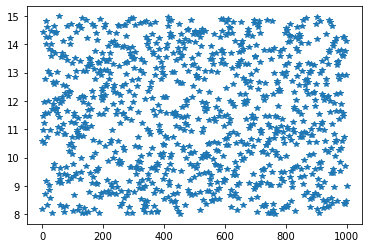

In [7]:
plt.plot(SNR,'*')
print('there are ',len(SNR),'unresolved signals')

In [8]:
# Numerical Derivatives - Source 1

logMchirp_delta = 1e-4
params_1_p = [logMchirp_1 + logMchirp_delta,eta_1,beta_1,Deff_1]
params_1_m = [logMchirp_1 - logMchirp_delta,eta_1,beta_1,Deff_1]

deriv_log_Mchirp_1 = (htilde(freq_bin,eps_AP,params_1_p) - htilde(freq_bin,eps_AP,params_1_m))/(2*logMchirp_delta)


eta_delta = 1e-6
params_1_p = [logMchirp_1,eta_1 + eta_delta,beta_1,Deff_1]
params_1_m = [logMchirp_1,eta_1 - eta_delta,beta_1,Deff_1]

deriv_log_eta_1 = (htilde(freq_bin,eps_AP,params_1_p) - htilde(freq_bin,eps_AP,params_1_m))/(2*eta_delta)



beta_delta = 1e-6
params_1_p = [logMchirp_1,eta_1,beta_1 + beta_delta,Deff_1]
params_1_m = [logMchirp_1,eta_1,beta_1 - beta_delta,Deff_1]

deriv_log_beta_1 = (htilde(freq_bin,eps_AP,params_1_p) - htilde(freq_bin,eps_AP,params_1_m))/(2*beta_delta)

# Source 2

logMchirp_delta = 1e-4
params_2_p = [logMchirp_2 + logMchirp_delta,eta_2,beta_2,Deff_2]
params_2_m = [logMchirp_2 - logMchirp_delta,eta_2,beta_2,Deff_2]

deriv_log_Mchirp_2 = (htilde(freq_bin,eps_AP,params_2_p) - htilde(freq_bin,eps_AP,params_2_m))/(2*logMchirp_delta)


eta_delta = 1e-6
params_2_p = [logMchirp_2,eta_2 + eta_delta,beta_2,Deff_2]
params_2_m = [logMchirp_2,eta_2 - eta_delta,beta_2,Deff_2]

deriv_log_eta_2 = (htilde(freq_bin,eps_AP,params_2_p) - htilde(freq_bin,eps_AP,params_2_m))/(2*eta_delta)



beta_delta = 1e-6
params_2_p = [logMchirp_2,eta_2,beta_2 + beta_delta,Deff_2]
params_2_m = [logMchirp_2,eta_2,beta_2 - beta_delta,Deff_2]

deriv_log_beta_2 = (htilde(freq_bin,eps_AP,params_2_p) - htilde(freq_bin,eps_AP,params_2_m))/(2*beta_delta)

# Source 3

logMchirp_delta = 1e-5
params_3_p = [logMchirp_3 + logMchirp_delta,eta_3,beta_3,Deff_3]
params_3_m = [logMchirp_3 - logMchirp_delta,eta_3,beta_3,Deff_3]

deriv_log_Mchirp_3 = (htilde(freq_bin,eps_AP,params_3_p) - htilde(freq_bin,eps_AP,params_3_m))/(2*logMchirp_delta)


eta_delta = 1e-5
params_3_p = [logMchirp_3,eta_3 + eta_delta,beta_3,Deff_3]
params_3_m = [logMchirp_3,eta_3 - eta_delta,beta_3,Deff_3]

deriv_log_eta_3 = (htilde(freq_bin,eps_AP,params_3_p) - htilde(freq_bin,eps_AP,params_3_m))/(2*eta_delta)



beta_delta = 1e-6
params_3_p = [logMchirp_3,eta_3,beta_3 + beta_delta,Deff_3]
params_3_m = [logMchirp_3,eta_3,beta_3 - beta_delta,Deff_3]

deriv_log_beta_3 = (htilde(freq_bin,eps_AP,params_3_p) - htilde(freq_bin,eps_AP,params_3_m))/(2*beta_delta)

# Source 4

logMchirp_delta = 1e-4
params_4_p = [logMchirp_4 + logMchirp_delta,eta_4,beta_4,Deff_4]
params_4_m = [logMchirp_4 - logMchirp_delta,eta_4,beta_4,Deff_4]

deriv_log_Mchirp_4 = (htilde(freq_bin,eps_AP,params_4_p) - htilde(freq_bin,eps_AP,params_4_m))/(2*logMchirp_delta)


eta_delta = 1e-6
params_4_p = [logMchirp_4,eta_4 + eta_delta,beta_4,Deff_4]
params_4_m = [logMchirp_4,eta_4 - eta_delta,beta_4,Deff_4]

deriv_log_eta_4 = (htilde(freq_bin,eps_AP,params_4_p) - htilde(freq_bin,eps_AP,params_4_m))/(2*eta_delta)



beta_delta = 1e-6
params_4_p = [logMchirp_4,eta_4,beta_4 + beta_delta,Deff_4]
params_4_m = [logMchirp_4,eta_4,beta_4 - beta_delta,Deff_4]

deriv_log_beta_4 = (htilde(freq_bin,eps_AP,params_4_p) - htilde(freq_bin,eps_AP,params_4_m))/(2*beta_delta)



diff_vec = [deriv_log_Mchirp_1,deriv_log_eta_1,deriv_log_beta_1,
            deriv_log_Mchirp_2,deriv_log_eta_2,deriv_log_beta_2,
            deriv_log_Mchirp_3,deriv_log_eta_3,deriv_log_beta_3,
            deriv_log_Mchirp_4,deriv_log_eta_4,deriv_log_beta_4]

fish_mix = np.eye(4*3)
for i in range(0,4*3):
    for j in range(0,4*3):
        fish_mix[i,j] = inner_prod(diff_vec[i],diff_vec[j],PSD,delta_f)
        
        

import mpmath as mp
mp.dps = 4000;  

fish_mix_prec = mp.matrix(fish_mix)

fish_mix_inv = fish_mix_prec**-1

Cov_Matrix = np.eye(4*3)
for i in range(0,4*3):
    for j in range(0,4*3):
        Cov_Matrix[i,j] = float(fish_mix_inv[i,j])

In [9]:
np.sqrt(np.diag(Cov_Matrix))[6:9]

array([8.45172295e-06, 1.90222897e-05, 6.82256154e-04])

In [10]:
# MCMC

# MCMC
"""
Created on Mon Nov 25 23:53:26 2019

@author: Ollie
"""

import numpy as np
import scipy as sp
import random as rd
import matplotlib.pyplot as plt

def llike(pdgrm, variances):
    """
    Computes log (Whittle) likelihood 
    """

    return -0.5 * sum(pdgrm / variances)

def lprior_logM_chirp(logM_chirp,logM_chirp_low, logM_chirp_high):
    """
    Prior on amplitude - uniform
    """

    if logM_chirp < logM_chirp_low or logM_chirp > logM_chirp_high:
        print('rejected logM_chirp')
        return -1e100
    else:
        return 0
    
def lprior_eta(eta,eta_low, eta_high):
    """
    Prior on amplitude - uniform
    """
    if eta < eta_low or eta > eta_high:
        print('rejected eta')

        return -1e100
    else:
        return 0
    
def lprior_beta(beta,beta_low, beta_high):
    """
    Prior on amplitude - uniform
    """

    if beta < beta_low or beta > beta_high:
        print('rejected beta')
        return -1e100
    else:
        return 0

    
def lpost(pdgrm, variances,
          logM_chirp_1,logM_chirp_2,logM_chirp_3, logM_chirp_4, logM_chirp_low,logM_chirp_high,
          eta_1, eta_2, eta_3, eta_4, eta_low, eta_high,
          beta_1, beta_2, beta_3, beta_4, beta_low, beta_high):
    '''
    Compute log posterior
    '''
    
    return(lprior_logM_chirp(logM_chirp_1,logM_chirp_low, logM_chirp_high) +
           lprior_logM_chirp(logM_chirp_2,logM_chirp_low, logM_chirp_high) +
           lprior_logM_chirp(logM_chirp_3,logM_chirp_low, logM_chirp_high) +
           lprior_logM_chirp(logM_chirp_4,logM_chirp_low, logM_chirp_high) +
           lprior_eta(eta_1,eta_low, eta_high) + 
           lprior_eta(eta_2,eta_low, eta_high) +
           lprior_eta(eta_3,eta_low, eta_high) +
           lprior_eta(eta_4,eta_low, eta_high) +
           lprior_beta(beta_1,beta_low, beta_high) +
           lprior_beta(beta_2,beta_low, beta_high) +
           lprior_beta(beta_3,beta_low, beta_high) +
           lprior_beta(beta_4,beta_low, beta_high) +
           + llike(pdgrm, variances))


def accept_reject(lp_prop, lp_prev):
    '''
    Compute log acceptance probability (minimum of 0 and log acceptance rate)
    Decide whether to accept (1) or reject (0)
    '''
    u = np.random.uniform(size = 1)  # U[0, 1]
    r = np.minimum(0, lp_prop - lp_prev)  # log acceptance probability
    if np.log(u) < r:
        return(1)  # Accept
    else:
        return(0)  # Reject
    
 

def accept_rate(parameter):
    '''
    Compute acceptance rate for a specific parameter
    Used to adapt the proposal variance in a MH sampler
    Input: parameter (sequence of samples of a parameter)
    '''
    rejections = 0
    for i in range(len(parameter) - 1):  # Count rejections
        rejections = rejections + (parameter[i + 1] == parameter[i])
    reject_rate = rejections / (len(parameter) - 1)  # Rejection rate
    return(1 - reject_rate)  # Return acceptance rate
    

#####
#####
    

def MCMC_full(data_f,f, true_vals,D_vec,Cov_Matrix,
                          Variances,
                           M_chirp_high,M_chirp_low,
                           eta_high, eta_low,
                           beta_high, beta_low,
                           Ntotal, 
                           burnin, 
                           printerval = 50):

    
    np.random.seed(2) # Set the seed
    
    
    logM_chirp_1 = []   # Initialise empty vectors
    eta_1 = []
    beta_1 = []
    Deff_1 = []
    
    logM_chirp_2 = []   # Initialise empty vectors
    eta_2 = []
    beta_2 = []
    Deff_2 = []
    
    logM_chirp_3 = []   # Initialise empty vectors
    eta_3 = []
    beta_3 = []
    Deff_3 = []
    
    logM_chirp_4 = []   # Initialise empty vectors
    eta_4 = []
    beta_4 = []
    Deff_4 = []   

    logM_chirp_1.append(true_vals[0])
    eta_1.append(true_vals[1])
    beta_1.append(true_vals[2])
    Deff_1.append(D_vec[0])
    
    logM_chirp_2.append(true_vals[3])
    eta_2.append(true_vals[4])
    beta_2.append(true_vals[5])
    Deff_2.append(D_vec[1])

    
    logM_chirp_3.append(true_vals[6])
    eta_3.append(true_vals[7])
    beta_3.append(true_vals[8])
    Deff_3.append(D_vec[2])
    
    logM_chirp_4.append(true_vals[9])
    eta_4.append(true_vals[10])
    beta_4.append(true_vals[11])
    Deff_4.append(D_vec[3])
    
    
    delta_f = f[1] - f[0]   # Extract sampling interval
    
    params_1 = [logM_chirp_1[0],eta_1[0],beta_1[0],Deff_1[0]]
    params_2 = [logM_chirp_2[0],eta_2[0],beta_2[0],Deff_2[0]]
    params_3 = [logM_chirp_3[0],eta_3[0],beta_3[0],Deff_3[0]]
    params_4 = [logM_chirp_4[0],eta_4[0],beta_4[0],Deff_4[0]]
    
    signal_init_f_1 = htilde(f,eps_AP,params_1)
    signal_init_f_2 = htilde(f,eps_AP,params_2)
    signal_init_f_3 = htilde(f,eps_AP,params_3)
    signal_init_f_4 = htilde(f,eps_AP,params_4)
    
    signal_f_init_tot = signal_init_f_1 + signal_init_f_2 +signal_init_f_3 + signal_init_f_4

    # Compute periodogram
    pdgrm = abs(data_f - signal_f_init_tot)**2  
    print('pdgrm is',pdgrm)
                                                      
    # Initial value for log posterior
    lp = []
    lp.append(lpost(pdgrm, variances,
                    logM_chirp_1[0], logM_chirp_2[0],logM_chirp_3[0],logM_chirp_4[0], logM_chirp_low, logM_chirp_high,
                    eta_1[0], eta_2[0], eta_3[0], eta_4[0], eta_low, eta_high,
                    beta_1[0], beta_2[0], beta_3[0], beta_4[0], beta_low, beta_high))
    
    lp_store = lp[0]  # Create log posterior storage to be overwritten

    accept_reject_count = [0]   
    #####                                                  
    # Run MCMC
    #####
    for i in range(1, Ntotal):

        if i % printerval == 0:
            print("i = ", i)  # Iteration and Acceptance/Rejection ratio 
            print("acceptance_reject ratio", 100*sum(accept_reject_count)/len(accept_reject_count),'percent')
            

        ####

        #####
        # Step 1: Sample spin, a
        #####
        
        lp_prev = lp_store  # Call previous stored log posterior
        
        # Hardcoded standard deviations because I'm a twat.
        
#         logM_chirp_prop = logM_chirp[i - 1] + np.random.normal(0,1.94471368e-05)
#         eta_prop = eta[i - 1] + np.random.normal(0,6.51506233e-04)
#         beta_prop = beta[i - 1] + np.random.normal(0,6.17458158e-03)

        prev_vec = [logM_chirp_1[i - 1], eta_1[i - 1], beta_1[i - 1],
                   logM_chirp_2[i - 1], eta_2[i - 1], beta_2[i - 1],
                   logM_chirp_3[i - 1], eta_3[i - 1], beta_3[i - 1],
                   logM_chirp_4[i - 1], eta_4[i - 1], beta_4[i - 1]]
    
        
        
        prop_vec = np.random.multivariate_normal(prev_vec, (1/4)*Cov_Matrix)
        
#         print(prop_vec)

        logM_chirp_prop_1 = prop_vec[0]
        eta_prop_1 = prop_vec[1]
        beta_prop_1 = prop_vec[2]
        
        logM_chirp_prop_2 = prop_vec[3]
        eta_prop_2 = prop_vec[4]
        beta_prop_2 = prop_vec[5]

        logM_chirp_prop_3 = prop_vec[6]
        eta_prop_3 = prop_vec[7]
        beta_prop_3 = prop_vec[8]
        
        logM_chirp_prop_4 = prop_vec[9]
        eta_prop_4 = prop_vec[10]
        beta_prop_4 = prop_vec[11]
        
#         print(eta_prop_1,eta_prop_2,eta_prop_3,eta_prop_4)
        
        param_1_prop = [logM_chirp_prop_1, eta_prop_1, beta_prop_1, Deff_1[0]]
        param_2_prop = [logM_chirp_prop_2, eta_prop_2, beta_prop_2, Deff_2[0]]
        param_3_prop = [logM_chirp_prop_3, eta_prop_3, beta_prop_3, Deff_3[0]]
        param_4_prop = [logM_chirp_prop_4, eta_prop_4, beta_prop_4, Deff_4[0]]
        
        signal_prop_f_1  = htilde(f,eps_AP,param_1_prop)  # New proposed signal
        signal_prop_f_2  = htilde(f,eps_AP,param_2_prop)  # New proposed signal
        signal_prop_f_3  = htilde(f,eps_AP,param_3_prop)  # New proposed signal
        signal_prop_f_4  = htilde(f,eps_AP,param_4_prop)  # New proposed signal
        
        signal_prop_f_tot = signal_prop_f_1 + signal_prop_f_2 + signal_prop_f_3 + signal_prop_f_4
        
        pdgrm_prop = abs(data_f - signal_prop_f_tot)**2  # Compute periodigram
        
        
        # Compute log posterior
        lp_prop = lpost(pdgrm_prop, variances, 
                         logM_chirp_prop_1,logM_chirp_prop_2,logM_chirp_prop_3,logM_chirp_prop_4,logM_chirp_low,logM_chirp_high,
                           eta_prop_1,eta_prop_2,eta_prop_3,eta_prop_4, eta_low, eta_high,
                             beta_prop_1, beta_prop_2, beta_prop_3, beta_prop_4, beta_low, beta_high)  # Compute proposed log posterior
        

        if accept_reject(lp_prop, lp_prev) == 1:  # Accept
            logM_chirp_1.append(logM_chirp_prop_1) 
            eta_1.append(eta_prop_1)
            beta_1.append(beta_prop_1)

            logM_chirp_2.append(logM_chirp_prop_2) 
            eta_2.append(eta_prop_2)
            beta_2.append(beta_prop_2)
            
            logM_chirp_3.append(logM_chirp_prop_3) 
            eta_3.append(eta_prop_3)
            beta_3.append(beta_prop_3)
            
            logM_chirp_4.append(logM_chirp_prop_4) 
            eta_4.append(eta_prop_4)
            beta_4.append(beta_prop_4)
            
            accept_reject_count.append(1)  # Add one to counter
              
            lp_store = lp_prop  # Overwrite lp_store

        else:  # Reject
            
            logM_chirp_1.append(logM_chirp_1[i - 1]) 
            eta_1.append(eta_1[i - 1])
            beta_1.append(beta_1[i - 1])

            logM_chirp_2.append(logM_chirp_2[i - 1]) 
            eta_2.append(eta_2[i - 1])
            beta_2.append(beta_2[i - 1])
            
            logM_chirp_3.append(logM_chirp_3[i - 1]) 
            eta_3.append(eta_3[i - 1])
            beta_3.append(beta_3[i - 1])
            
            logM_chirp_4.append(logM_chirp_4[i - 1]) 
            eta_4.append(eta_4[i - 1])
            beta_4.append(beta_4[i - 1])
            
            accept_reject_count.append(0)  # Add 0 to counter
              
        lp.append(lp_store)  # Add log posterior value
        


        
    return logM_chirp_1,eta_1,beta_1,logM_chirp_2,eta_2,beta_2,logM_chirp_3,eta_3,beta_3,logM_chirp_4,eta_4,beta_4,lp

In [11]:

variances = (PSD)/(4*delta_f)   # Variances (denominator of likelihood)

noise_1 = np.random.normal(0,np.sqrt(variances))
noise_2 = np.random.normal(0,np.sqrt(variances))

noise_f = noise_1 + 1j*noise_2

data_f = h_f_1 + h_f_2 + h_f_3 + h_f_4 + sum_unres_h_f + noise_f

Ntotal = 100000  # Number of iterations
burnin = 0

logM_chirp_low = -100   # a prior bound (high)
logM_chirp_high = np.log(3e10)     # a prior bound (low)

eta_low = 0
eta_high = 0.25

beta_low = 0
beta_high = 9.4


true_vals = [np.log(M_chirp_1),eta_1,beta_1,
            np.log(M_chirp_2),eta_2,beta_2,
            np.log(M_chirp_3),eta_3,beta_3,
            np.log(M_chirp_4),eta_4,beta_4]  # True values to start chain with 

D_vec = [Deff_1,Deff_2,Deff_3,Deff_4]

# Run the algorithm
logM_chirp_1_samps,eta_1_samps,beta_1_samps,logM_chirp_2_samps,eta_2_samps,beta_2_samps,logM_chirp_3_samps,eta_3_samps,beta_3_samps,logM_chirp_4_samps,eta_4_samps,beta_4_samps,lp = MCMC_full(data_f,
                                                   freq_bin, true_vals,D_vec,Cov_Matrix,
                                                   variances,
                                                   logM_chirp_high,logM_chirp_low,
                                                   eta_high,eta_low,
                                                   beta_high,beta_low,
                                                   Ntotal, 
                                                   burnin, 
                                                   printerval = 2000,
                                                   )


# logM_chirp_samps = logM_chirp_samps[burnin:]
# eta_samps = eta_samps[burnin:]
# beta_samps = beta_samps[burnin:]
# lp = lp[burnin:]

pdgrm is [6.11845388e-28 2.11274871e-27 2.60580283e-27 ... 1.78039098e-30
 2.03898466e-30 7.62105022e-31]
i =  2000
acceptance_reject ratio 42.05 percent
i =  4000
acceptance_reject ratio 41.425 percent
i =  6000
acceptance_reject ratio 41.03333333333333 percent
i =  8000
acceptance_reject ratio 41.35 percent
i =  10000
acceptance_reject ratio 41.35 percent
i =  12000
acceptance_reject ratio 40.916666666666664 percent
i =  14000
acceptance_reject ratio 40.785714285714285 percent
i =  16000
acceptance_reject ratio 40.5875 percent
i =  18000
acceptance_reject ratio 40.888888888888886 percent
i =  20000
acceptance_reject ratio 40.76 percent
i =  22000
acceptance_reject ratio 40.61818181818182 percent
i =  24000
acceptance_reject ratio 40.4875 percent
i =  26000
acceptance_reject ratio 40.534615384615385 percent
i =  28000
acceptance_reject ratio 40.39642857142857 percent
i =  30000
acceptance_reject ratio 40.38 percent
i =  32000
acceptance_reject ratio 40.3625 percent
i =  34000
acceptan

In [12]:
# burnin = 5000

# logM_chirp_1_samps = logM_chirp_1_samps[burnin:]
# eta_1_samps = eta_1_samps[burnin:]
# beta_1_samps = beta_1_samps[burnin:]

# logM_chirp_2_samps = logM_chirp_2_samps[burnin:]
# eta_2_samps = eta_2_samps[burnin:]
# beta_2_samps = beta_2_samps[burnin:]

# logM_chirp_3_samps = logM_chirp_3_samps[burnin:]
# eta_3_samps = eta_3_samps[burnin:]
# beta_3_samps = beta_3_samps[burnin:]

# logM_chirp_4_samps = logM_chirp_4_samps[burnin:]
# eta_4_samps = eta_4_samps[burnin:]
# beta_4_samps = beta_4_samps[burnin:]


In [13]:
print("Source 1")
print('MCMC logM_chirp:',np.sqrt(np.var(logM_chirp_1_samps)))
print('MCMC eta:',np.sqrt(np.var(eta_1_samps)))
print('MCMC beta:',np.sqrt(np.var(beta_1_samps)))

print('FM:',np.sqrt(np.diag(Cov_Matrix)[0:3]))

print("Source 2")
print('MCMC logM_chirp:',np.sqrt(np.var(logM_chirp_2_samps)))
print('MCMC eta:',np.sqrt(np.var(eta_2_samps)))
print('MCMC beta:',np.sqrt(np.var(beta_2_samps)))

print('FM:',np.sqrt(np.diag(Cov_Matrix)[3:6]))

print("Source 3")
print('MCMC logM_chirp:',np.sqrt(np.var(logM_chirp_3_samps)))
print('MCMC eta:',np.sqrt(np.var(eta_3_samps)))
print('MCMC beta:',np.sqrt(np.var(beta_3_samps)))

print('FM:',np.sqrt(np.diag(Cov_Matrix)[6:9]))

print("Source 4")
print('MCMC logM_chirp:',np.sqrt(np.var(logM_chirp_4_samps)))
print('MCMC eta:',np.sqrt(np.var(eta_4_samps)))
print('MCMC beta:',np.sqrt(np.var(beta_4_samps)))

print('FM:',np.sqrt(np.diag(Cov_Matrix)[9:12]))

Source 1
MCMC logM_chirp: 8.886959201019668e-05
MCMC eta: 0.00038960409328377815
MCMC beta: 0.01801850171326831
FM: [8.45199337e-05 3.64716444e-04 1.69207845e-02]
Source 2
MCMC logM_chirp: 1.684756476119652e-05
MCMC eta: 5.102289798536171e-05
MCMC beta: 0.00289510313786577
FM: [1.61924102e-05 4.66601312e-05 2.63473104e-03]
Source 3
MCMC logM_chirp: 1.2102242017975317e-05
MCMC eta: 1.9583710071422012e-05
MCMC beta: 0.0006895794296106899
FM: [8.45172295e-06 1.90222897e-05 6.82256154e-04]
Source 4
MCMC logM_chirp: 1.0173544953462065e-05
MCMC eta: 6.419887255210008e-05
MCMC beta: 0.0021786406352989614
FM: [1.00404554e-05 6.33497813e-05 2.14175980e-03]


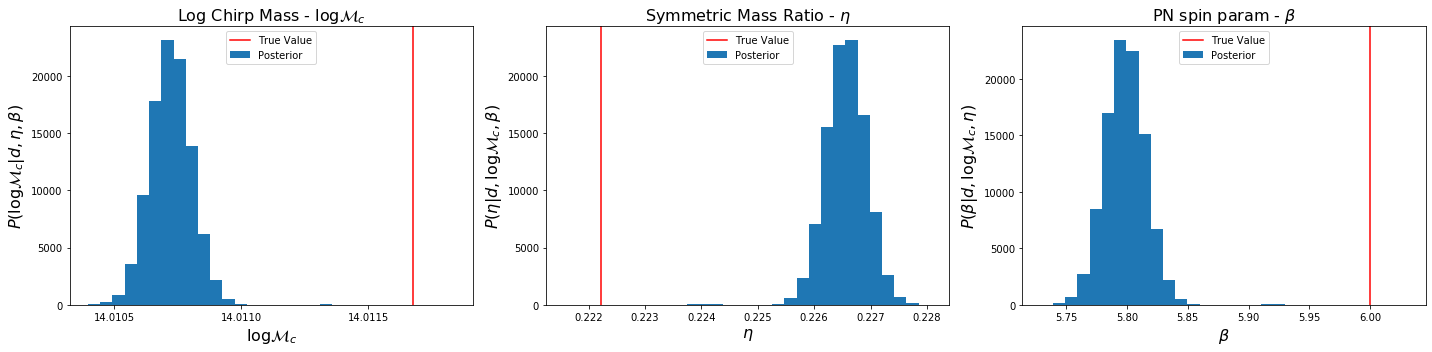

In [14]:
# Results

fig,ax = plt.subplots(1,3,figsize = (20,5))

ax[0].hist(logM_chirp_1_samps,bins = 30,label = 'Posterior')
ax[0].axvline(x = np.log(M_chirp_1),c = 'red', label = 'True Value')
# ax[0].axvline(x = a_res + a_bias, color = 'g', label = 'Predicted bias')
ax[0].set_xlabel(r'$\log \mathcal{M}_{c}$',fontsize = 16)
ax[0].set_ylabel(r'$P(\log \mathcal{M}_{c}|d,\eta,\beta)$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}_{c}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_1_samps,bins = 30,label = 'Posterior')
ax[1].axvline(x = eta_1,c = 'red', label = 'True Value')
# ax[1].axvline(x = f_res + f0_bias, color = 'g', label = 'Predicted bias')
ax[1].set_xlabel(r'$\eta$',fontsize = 16)
ax[1].set_ylabel(r'$P(\eta|d,\log \mathcal{M}_{c},\beta)$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_1_samps,bins = 30,label = 'Posterior')
ax[2].axvline(x = beta_1,c = 'red', label = 'True Value')
# ax[2].axvline(x = phi_res + phi_bias,c = 'g',label = 'Predicted bias' )
ax[2].set_xlabel(r'$\beta$',fontsize = 16)
ax[2].set_ylabel(r'$P(\beta|d,\log \mathcal{M}_{c},\eta)$',fontsize = 16)
ax[2].set_title(r'PN spin param - $\beta$',fontsize = 16)
ax[2].legend()
# ax[2].show()
plt.tight_layout()

In [15]:
# FM formalism

deltaH = sum_unres_h_f

waveform_errors = (htilde(freq_bin,eps_GR,pars_1) - htilde(freq_bin,eps_AP,pars_1) + 
                   htilde(freq_bin,eps_GR,pars_2) - htilde(freq_bin,eps_AP,pars_2) + 
                   htilde(freq_bin,eps_GR,pars_3) - htilde(freq_bin,eps_AP,pars_3) + 
                   htilde(freq_bin,eps_GR,pars_4) - htilde(freq_bin,eps_AP,pars_4))

deltah = noise_f + waveform_errors + deltaH

b_vec = [inner_prod(diff_vec[i],deltah,PSD,delta_f) for i in range(0,12)]

biases_pred_unresolved = np.matmul(Cov_Matrix,b_vec)

b_vec_n = [inner_prod(diff_vec[i],noise_f,PSD,delta_f) for i in range(0,12)]
b_vec_waveform_errors = [inner_prod(diff_vec[i],waveform_errors,PSD,delta_f) for i in range(0,12)]
b_vec_unresolved_signals = [inner_prod(diff_vec[i],deltaH,PSD,delta_f) for i in range(0,12)]


biases_pred_n = np.matmul(Cov_Matrix,b_vec_n)
biases_pred_waveform_errors = np.matmul(Cov_Matrix,b_vec_waveform_errors)
biases_pred_unresolved = np.matmul(Cov_Matrix,b_vec_unresolved_signals)

biases_pred_unresolved_total =  biases_pred_waveform_errors + biases_pred_unresolved +biases_pred_n 

In [16]:
biases_pred_waveform_errors

array([ 4.01993640e-05, -2.76705760e-04,  1.14496553e-02, -3.57054398e-05,
        2.18653701e-05, -2.40414417e-03, -8.14512879e-05,  1.39695653e-04,
       -7.95739904e-03, -1.23749212e-04,  3.59469295e-04, -1.52356136e-02])

In [17]:
M_chirp_bias_1 = biases_pred_unresolved_total[0]
eta_bias_1 = biases_pred_unresolved_total[1]
beta_bias_1 = biases_pred_unresolved_total[2]

In [18]:
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

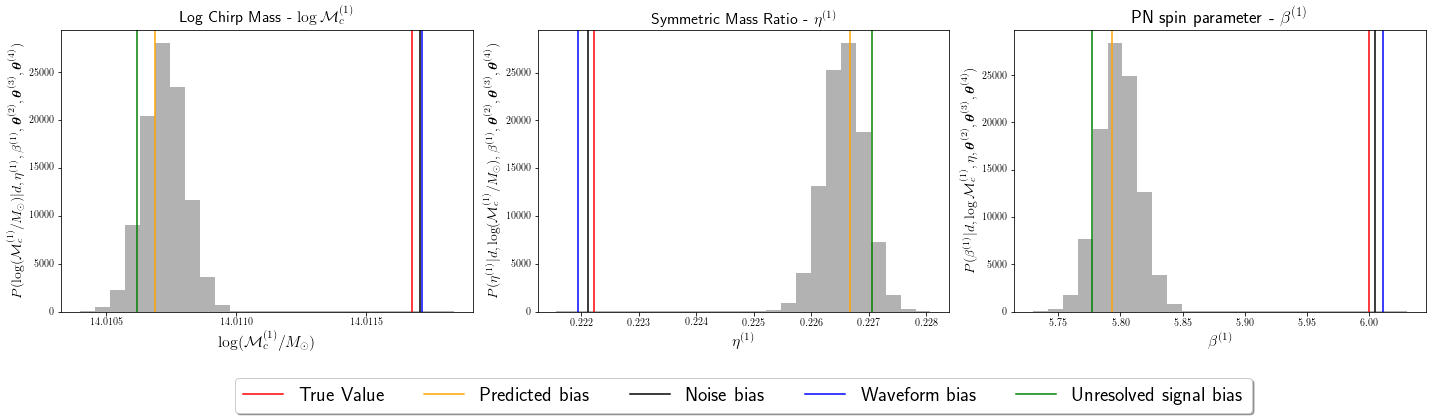

In [19]:
# Results


fig,ax = plt.subplots(1,3,figsize = (20,6))
alpha_val = 0.3

ax[0].hist(logM_chirp_1_samps,bins = 25,color = 'black', histtype = 'stepfilled', alpha = alpha_val)
ax[0].axvline(x = np.log(M_chirp_1),color = 'red',  label = 'True Value')
ax[0].axvline(x = np.log(M_chirp_1) + M_chirp_bias_1, color = 'orange', label = 'Predicted bias')
ax[0].axvline(x = np.log(M_chirp_1) + biases_pred_n[0],c = 'black',label = 'Noise bias' )
ax[0].axvline(x = np.log(M_chirp_1) + biases_pred_waveform_errors[0],c = 'blue',label = 'Waveform bias' )
ax[0].axvline(x = np.log(M_chirp_1) + biases_pred_unresolved[0],c = 'green',label = 'Unresolved  signal bias' )
ax[0].set_xlabel(r'$\log (\mathcal{M}^{(1)}_{c}/M_{\odot})$',fontsize = 16)
ax[0].set_ylabel(r'$P(\log (\mathcal{M}^{(1)}_{c}/M_{\odot})|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 14)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}^{(1)}_{c}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[0].locator_params(axis='x', nbins=5)
# ax[0].show()



ax[1].hist(eta_1_samps,bins = 25, color = 'black', alpha = alpha_val)
ax[1].axvline(x = eta_1,c = 'red', label = 'True Value')
ax[1].axvline(x = eta_1 + eta_bias_1, color = 'orange', label = 'Predicted bias')
ax[1].axvline(x = eta_1 + biases_pred_n[1],c = 'black',label = 'Noise bias' )
ax[1].axvline(x = eta_1 + biases_pred_waveform_errors[1],c = 'blue',label = 'Waveform bias' )
ax[1].axvline(x = eta_1 + biases_pred_unresolved[1],c = 'green',label = 'Unresolved signal bias' )
ax[1].set_xlabel(r'$\eta^{(1)}$',fontsize = 16)
ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log (\mathcal{M}^{(1)}_{c}/M_{\odot}),\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 14)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta^{(1)}$',fontsize = 16)
# plt.xlim([1.794,1.803])
# ax[1].legend()
# ax[1].show()


ax[2].hist(beta_1_samps,bins = 25, color = 'black', histtype = 'stepfilled', alpha = alpha_val)
ax[2].axvline(x = beta_1,c = 'red', label = 'True Value')
ax[2].axvline(x = beta_1 + beta_bias_1,c = 'orange',label = 'Predicted bias' )
ax[2].axvline(x = beta_1 + biases_pred_n[2],c = 'black',label = 'Noise bias' )
ax[2].axvline(x = beta_1 + biases_pred_waveform_errors[2],c = 'blue',label = 'Waveform bias' )
ax[2].axvline(x = beta_1 + biases_pred_unresolved[2],c = 'green',label = 'Unresolved signal bias' )
ax[2].set_xlabel(r'$\beta^{(1)}$',fontsize = 16)
ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 14)
ax[2].set_title(r'PN spin parameter - $\beta^{(1)}$',fontsize = 18)
# ax[2].legend(fontsize = 16)

# ax[0].tick_params(axis='both', which='major', labelsize=15)
# ax[1].tick_params(axis='both', which='major', labelsize=15)
# ax[2].tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

box = ax[1].get_position()
# ax[1].set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

# Put a legend below current axis
ax[1].legend(fontsize = 20, loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, shadow=True, ncol=5)

fig.subplots_adjust(bottom=0.27)
# ax[2].show()

os.chdir('/Users/Ollie/Documents/GitHub_Repositories/population-systematics/Codes/OB/GW_Sources/TaylorF2_Examples/LISA_case/plots')
plt.savefig("LISA_3_post_unres_res_errors_big_H.pdf")

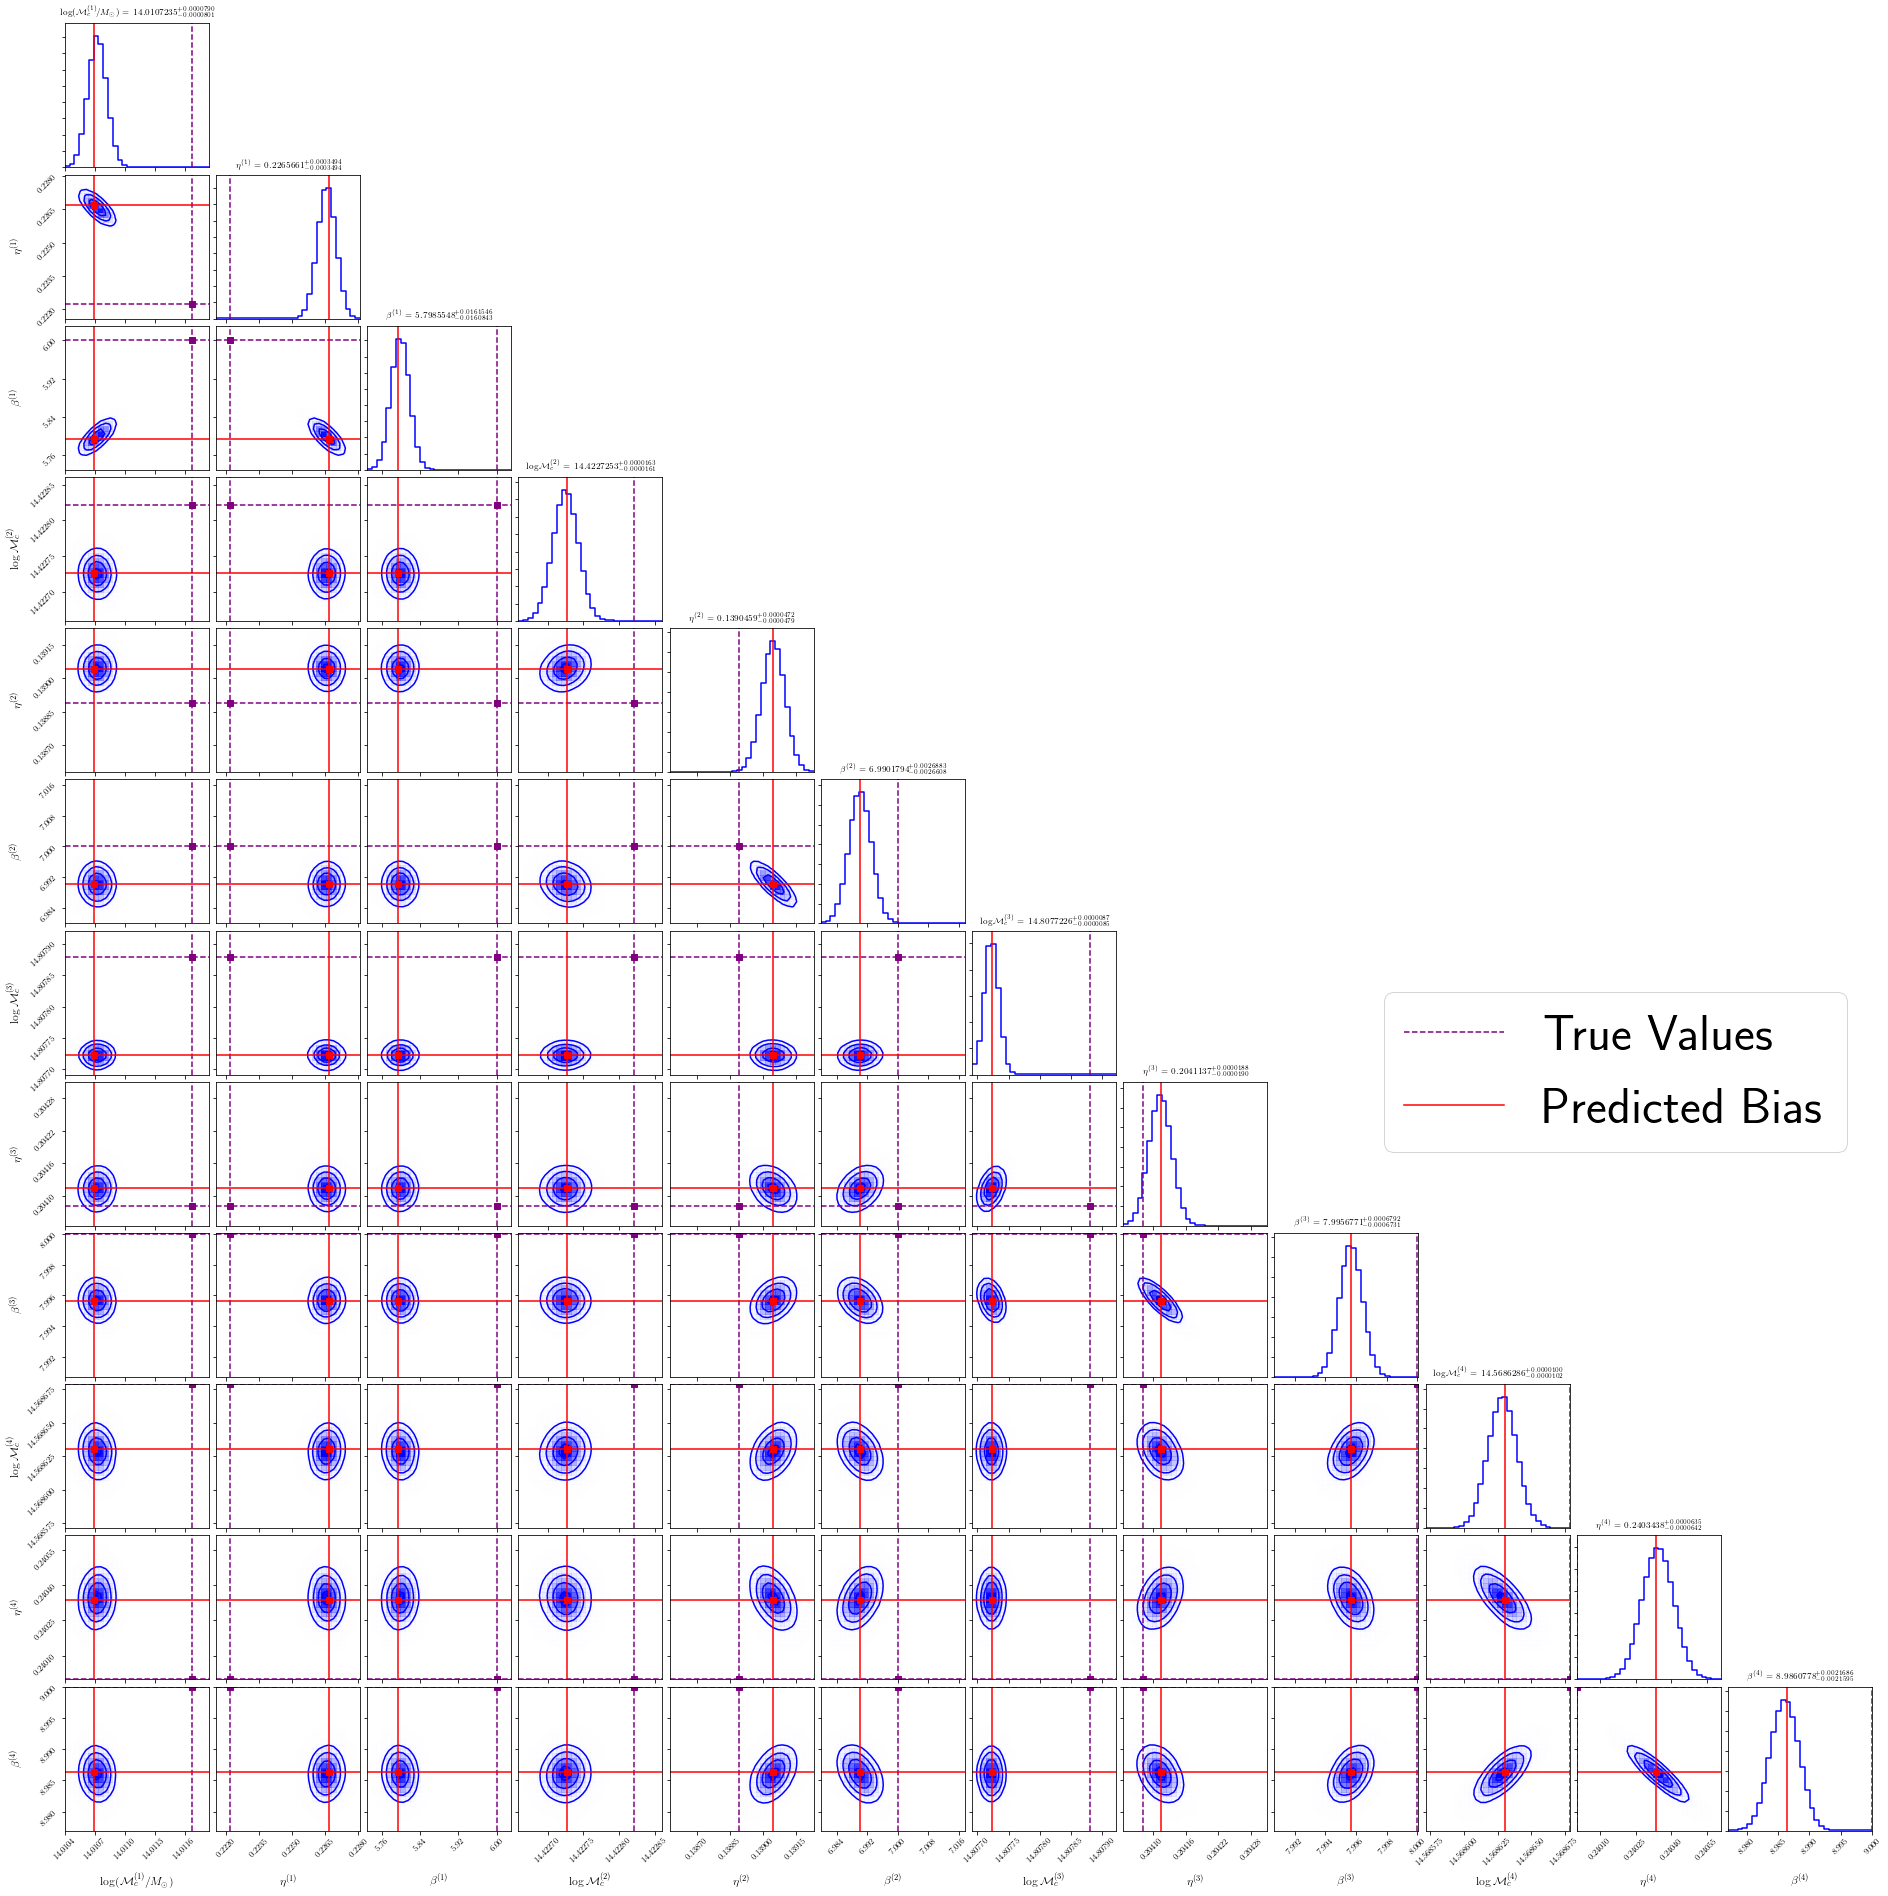

In [20]:

import corner
samples = np.column_stack([logM_chirp_1_samps,eta_1_samps,beta_1_samps,
                          logM_chirp_2_samps,eta_2_samps,beta_2_samps,
                          logM_chirp_3_samps,eta_3_samps,beta_3_samps,
                          logM_chirp_4_samps,eta_4_samps,beta_4_samps])

figure = corner.corner(samples,bins = 30, color = 'blue',plot_datapoints=False,smooth1d=True,
                       labels=[r"$\log (\mathcal{M}^{(1)}_{c}/M_{\odot})$", r"$\eta^{(1)}$", r"$\beta^{(1)}$",
                              r"$\log \mathcal{M}^{(2)}_{c}$", r"$\eta^{(2)}$", r"$\beta^{(2)}$",
                              r"$\log \mathcal{M}^{(3)}_{c}$", r"$\eta^{(3)}$", r"$\beta^{(3)}$",
                              r"$\log \mathcal{M}^{(4)}_{c}$", r"$\eta^{(4)}$", r"$\beta^{(4)}$"],
                       label_kwargs = {"Fontsize":12},set_xlabel = {'fontsize': 20},
                       show_titles=True, title_fmt='.7f',title_kwargs={"fontsize": 9},smooth = True)

axes = np.array(figure.axes).reshape((12,12))
true_vals = [np.log(M_chirp_1),eta_1,beta_1,
             np.log(M_chirp_2),eta_2,beta_2,
             np.log(M_chirp_3),eta_3,beta_3,
             np.log(M_chirp_4),eta_4,beta_4]
for i in range(12):
    ax = axes[i, i]
    ax.axvline(true_vals[i], color="purple",linestyle = "--",label = 'True Values')
    ax.axvline(true_vals[i] + biases_pred_unresolved_total[i] , color="red",label = 'Predicted Bias')
    
for yi in range(12):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axhline(true_vals[yi], color="purple",linestyle = "--")
        ax.axvline(true_vals[xi],color= "purple",linestyle = "--")
        ax.axvline(true_vals[xi] + biases_pred_unresolved_total[xi] , color="red")
        ax.axhline(true_vals[yi] + biases_pred_unresolved_total[yi] , color="red")
        ax.plot(true_vals[xi], true_vals[yi], color = "purple",marker='s')
        ax.plot(true_vals[xi] + biases_pred_unresolved_total[xi] , true_vals[yi] + biases_pred_unresolved_total[yi],
                color="red",marker='s')
        
for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=8)
    
plt.legend(bbox_to_anchor=(1, 6),fontsize = 50)
# os.chdir('/Users/Ollie/Documents/GitHub_Repositories/population-systematics/Codes/OB/GW_Sources/TaylorF2_Examples/LISA_case/plots')
# plt.savefig("LISA_Corner.pdf")
#median given here.

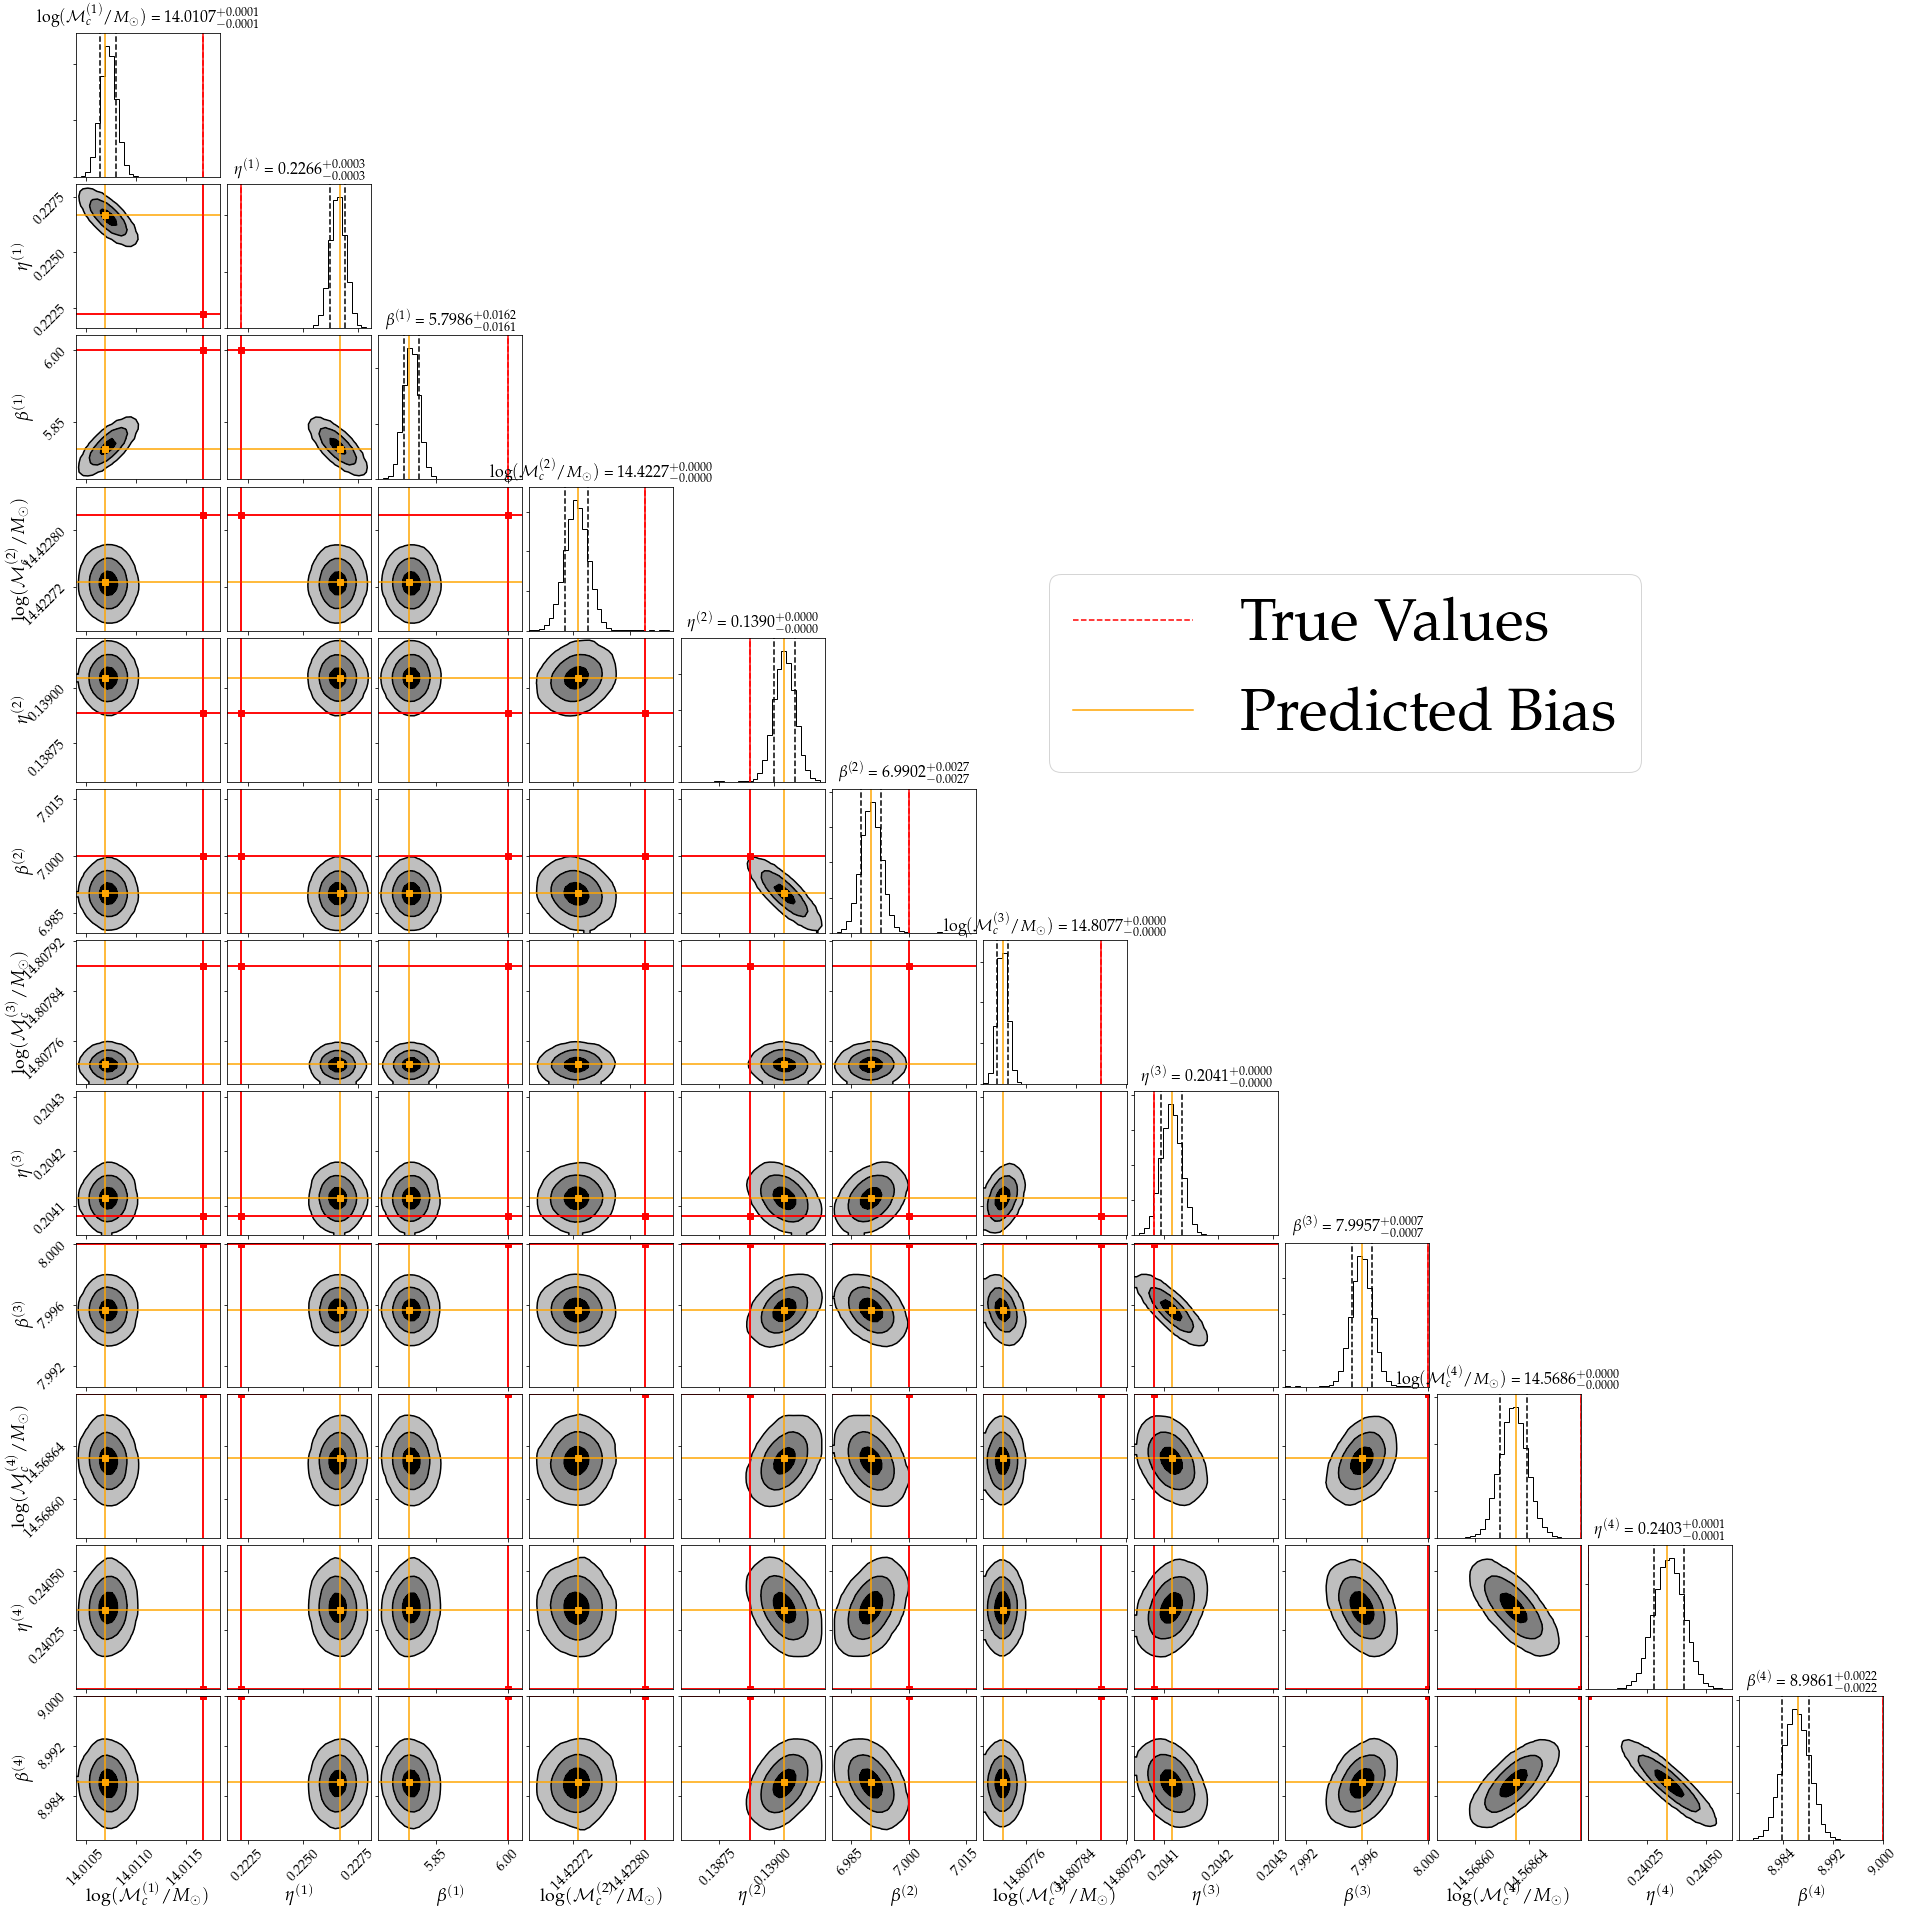

In [21]:
plt.rcParams.update({'text.usetex': True,'font.family': 'serif', 'font.serif': ['Palatino'],'font.size':14})

import matplotlib as mpl
import matplotlib.patches as mpatches

# mpl.rcParams[‘axes.formatter.useoffset’] = False
CORNER_KWARGS = dict(
    smooth=0.99, # smooths out contours.
    plot_datapoints=False, # choose if you want datapoints
    label_kwargs=dict(fontsize=18), # font size for labels
    show_titles=True, #choose if you want titles on top of densities.
    title_kwargs=dict(fontsize=16), # font size for title
    plot_density=False,
    quantiles=[0.16, 0.84],  # add quantiles to plot densities.
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours=True, #decide if you want to fill the contours
    max_n_ticks=3, # set a limit to ticks in the x-y axes.
    title_fmt='.4f', # format for high powers (here 10^2 ~ e+02 etc.)
    reverse=False  # if you are a madman, reverse the whole contour.
)

labels =[r"$\log (\mathcal{M}^{(1)}_{c}/M_{\odot})$", r"$\eta^{(1)}$", r"$\beta^{(1)}$",
          r"$\log (\mathcal{M}^{(2)}_{c}/M_{\odot})$", r"$\eta^{(2)}$", r"$\beta^{(2)}$",
          r"$\log (\mathcal{M}^{(3)}_{c}/M_{\odot})$", r"$\eta^{(3)}$", r"$\beta^{(3)}$",
          r"$\log (\mathcal{M}^{(4)}_{c}/M_{\odot})$", r"$\eta^{(4)}$", r"$\beta^{(4)}$"]
true_vals = [np.log(M_chirp_1),eta_1,beta_1,
             np.log(M_chirp_2),eta_2,beta_2,
             np.log(M_chirp_3),eta_3,beta_3,
             np.log(M_chirp_4),eta_4,beta_4]

fig = corner.corner(samples, bins=30,labels=labels,
                    truths=true_vals, 
                    truth_color="red",
                    color="black",**CORNER_KWARGS)
red_patch = mpatches.Patch(color="red", label="True values")

axes = np.array(fig.axes).reshape((12,12))

for i in range(12):
    ax = axes[i, i]
    ax.axvline(true_vals[i], color="red",linestyle = "--",label = 'True Values')
    ax.axvline(true_vals[i] + biases_pred_unresolved_total[i] , color="orange",label = 'Predicted Bias')
    
for yi in range(12):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(true_vals[xi] + biases_pred_unresolved_total[xi] , color="orange")
        ax.axhline(true_vals[yi] + biases_pred_unresolved_total[yi] , color="orange")
        ax.plot(true_vals[xi] + biases_pred_unresolved_total[xi] , true_vals[yi] + biases_pred_unresolved_total[yi],
                color="orange",marker='s')
        ax.axhline(true_vals[yi], color="red")
        ax.axvline(true_vals[xi],color= "red")

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=8)
        
plt.legend(fontsize = 60,bbox_to_anchor=(-5., 9),
           loc="upper left")


os.chdir('/Users/Ollie/Documents/GitHub_Repositories/population-systematics/Codes/OB/GW_Sources/TaylorF2_Examples/LISA_case/plots')
plt.savefig("LISA_Corner_imp_big_H.pdf")